# jelli - a JAX-based EFT likelihood: an example notebook

In this example notebook we demonstrate the basics of `jelli` on a small subset of the future `smelli 3.0` dataset.

To install `jelli`, you can use pip:

```bash
pip install jelli
```

This will automatically install the required dependencies, including `rgevolve` - a new package providing RG evolution matrices in various EFTs and bases.

For plotting purposes, we will also use `matplotlib` and `flavio.plots`, so please install them as well:

```bash
pip install matplotlib flavio
```

## Import jelli

In [1]:
from jelli import GlobalLikelihood, ObservableSector

## Load the data

This command automatically loads all appropriate data from the `data` folder. This includes:
- polynomial observable prediction files (in POPxf compliant .json files, e.g. `bdmumu.json`)
- measurement files (in .json files, e.g. `measurements_tails_ee.json`)
- theory correlation matrices (in POPxf compliant .hdf5 files, e.g. `th_correlation_matrix.hdf5`)

In the background, many things are prepared for efficient evaluation, e.g.:
- appropriate RG evolution matrices are extracted for all observable sectors
- efficient prediction functions are defined for all observables
- data required for evaluating all experimental likelihoods is processed 

In [2]:
GlobalLikelihood.load('data/')

We can print the names of all loaded observable sectors:

In [3]:
ObservableSector.get_all_names()

['bdee', 'bdmumu', 'tails_ee']

We can print the names of all observables in one observable sector:

In [4]:
ObservableSector.get('bdmumu').observable_names

['BR(B0->mumu)',
 'BR_LHCb(Bs->K*0mumu)',
 "('<dBR/dq2>(B+->pimumu)', 2.0, 4.0)",
 "('<dBR/dq2>(B+->pimumu)', 15.0, 22.0)",
 "('<dBR/dq2>(B+->pimumu)', 4.0, 6.0)"]

## Define a GlobalLikelihood instance and evaluate the likelihoods

Defining a `GlobalLikelihood` instance requires selecting which EFT and basis we are working in. In this example, we will use the `SMEFT` in the `Warsaw` basis. In the background, the `GlobalLikelihood` instance will automatically select all observable sectors that can have predictions in this EFT and basis (all of them as we also have the SMEFT->WET matching at our disposal), and define all required functions, e.g. a highly efficient likelihood function.

In [5]:
gl = GlobalLikelihood('SMEFT', 'Warsaw')

The number of observables in this likelihood is:

In [6]:
len(gl.observables_gaussian + gl.observables_no_theory_uncertainty)

216

Check that we have rgevolve available:

In [7]:
gl.basis_mode

'rgevolve'

We will use a user interface similar to `smelli` here to obtain the log likelihood values for all available likelihoods, and for the global likelihood.

As an example, we consider a two parameter scenario with the Wilson coefficients $[C_{qe}]_{1311}$ and $[C_{ed}]_{1113}$.

In [8]:
def wc_func(x, y):
    return {
        'qe_1311': x,
        'ed_1113': y,
    }
wc_func(1e-8, -1e-8)

{'qe_1311': 1e-08, 'ed_1113': -1e-08}

Assuming the coefficients take the value of $\pm10^{-8} \mathrm{GeV}^{-2}$ at the scale of $1000~\mathrm{GeV}$, we define a parameter point:

In [9]:
glp = gl.parameter_point(wc_func(1e-8, -1e-8), 1000.0)

Then we can obtain the dictonary of log likelihood (differences with respect to SM) for all likelihoods. Note, that the first time we run this, the likelihood function in the background will be JIT-compiled. 

The output dictionary is organised so that correlated observable sectors are grouped into tuples, while the rest are simply listed according to their names. The final entry is the global likelihood.

In [10]:
glp.log_likelihood_dict()

{('bdee', 'bdmumu'): Array(0.2776509, dtype=float64),
 'tails_ee': Array(0.28110913, dtype=float64),
 'global': Array(0.55876003, dtype=float64)}

If we are now interested in other values of these Wilson coefficients, or another scale, or completely different Wilson coefficients in this EFT, we can simply define new parameter points, and evaluate the likelihoods again, which will now be very fast thanks to the JIT compilation.

In [11]:
glp = gl.parameter_point(wc_func(0.5*1e-8, -1e-8), 1000.0)  # another value of Wilson coefficients
glp.log_likelihood_dict()

{('bdee', 'bdmumu'): Array(-17.10677235, dtype=float64),
 'tails_ee': Array(0.17926978, dtype=float64),
 'global': Array(-16.92750258, dtype=float64)}

In [12]:
glp = gl.parameter_point(wc_func(0.5*1e-8, -1e-8), 3000.0)  # another scale
glp.log_likelihood_dict()

{('bdee', 'bdmumu'): Array(-16.85077666, dtype=float64),
 'tails_ee': Array(0.17758451, dtype=float64),
 'global': Array(-16.67319215, dtype=float64)}

In [13]:
def wc_func_mu(x, y):
    return {
        'qe_1322': x,  # muons instead of electrons
        'ed_2213': y,
    }
glp = gl.parameter_point(wc_func_mu(5e-10, -5e-10), 1000.0)
glp.log_likelihood_dict()

{('bdee', 'bdmumu'): Array(-1.95317241, dtype=float64),
 'tails_ee': Array(-1.98951966e-13, dtype=float64),
 'global': Array(-1.95317241, dtype=float64)}

## Example plot: Interplay between low- and high-energy constraints + RG effects
(from arxiv:2212.10497)

Here we define a few custom likelihoods: these are defined by sets of observables that we wish to include in each likelihood. They are then treated like any other likelihood (e.g. we can plot them), except that they are not separately included in the global likelihood.

In [14]:
custom_likelihoods = {
    'bdmumu': ['BR(B0->mumu)', 'BR_LHCb(Bs->K*0mumu)', "('<dBR/dq2>(B+->pimumu)', 2.0, 4.0)",
                "('<dBR/dq2>(B+->pimumu)', 15.0, 22.0)", "('<dBR/dq2>(B+->pimumu)', 4.0, 6.0)"],
    'bdee': ['BR_Belle(B+->piee)'],
}

gl2 = GlobalLikelihood(eft='SMEFT', basis='Warsaw', custom_likelihoods=custom_likelihoods)

We are interested in the scenario in which two Wilson coefficients are active: $[C_{qe}]_{1311}$ and $[C_{ed}]_{1113}$, both at the scale of $1 ~\mathrm{TeV}$. Note, that this time we also obtain the results of each custom likelihood that we defined above.

In [15]:
def wc_func2(x, y):
    return {
        'qe_1311': x/1000**2,  # this time we conveniently rescale the coefficients inside the function
        'ed_1113': y/1000**2,
    }

glp = gl2.parameter_point(wc_func2(0.01, -0.015), 1000.0)
glp.log_likelihood_dict()

{('bdee', 'bdmumu'): Array(-16.04871125, dtype=float64),
 'tails_ee': Array(0.43929351, dtype=float64),
 'custom_bdee': Array(-16.43570116, dtype=float64),
 'custom_bdmumu': Array(0.15061317, dtype=float64),
 'global': Array(-15.60941774, dtype=float64)}

Minimize the $\chi^2$ functions to find the best fit points in this scenario:

In [16]:
from flavio.math.optimize import minimize

In [17]:
def chi2(x, likelihood):  # not the most efficient way to do this, but works
    glp = gl2.parameter_point(wc_func2(x[0], x[1]), 1000.0)
    return -2*float(glp.log_likelihood_dict()[likelihood])

In [18]:
min_bdee = minimize(chi2, [0.01, -0.01], method='Nelder-Mead', tol=1e-6, args=('custom_bdee',))
min_bdmumu = minimize(chi2, [0.01, -0.01], method='Nelder-Mead', tol=1e-6, args=('custom_bdmumu',))
min_tails_ee = minimize(chi2, [0.01, -0.01], method='Nelder-Mead', tol=1e-6, args=('tails_ee',))
min_global = minimize(chi2, [0.01, -0.01], method='Nelder-Mead', tol=1e-6, args=('global',))

Scan the parameter space in two dimensions:

In [19]:
plot_data = gl2.plot_data_2d(
    wc_func2,
    scale=1000.0,
    x_min=-0.06, x_max=0.06,
    y_min=-0.06, y_max=0.06,
    steps=70,  # (together 70*70 = 4900 points)
)

Now we import the plotting libraries and define a function to return the $\chi^2$ values corresponding to given confidence levels

In [20]:
import matplotlib.pyplot as plt
import flavio.plots as fpl

def sigma(*args, dof=2):
    return [fpl.delta_chi2(n_sigma, dof=dof) for n_sigma in args]

Notice the narrow flat direction in $B\to \pi e e$, the complementary constraints from $pp\to e e$ and the RG effect from $b\to d \mu \mu$.

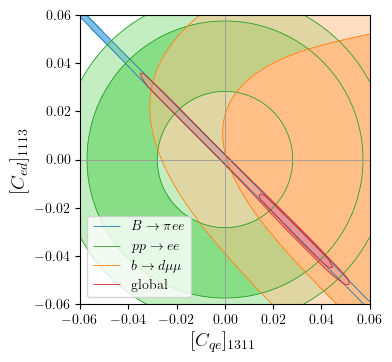

In [21]:
plt.figure(figsize=(4,4))
fpl.contour(**plot_data['custom_bdee'], levels=sigma(1, dof=1), label=r'$B \to \pi e e$', color='C0', interpolation_factor=1, z_min=min_bdee.fun)
fpl.contour(**plot_data['tails_ee'], levels=sigma(1,2, dof=1), label=r'$pp \to e e$', color='C2', interpolation_factor=1, z_min=min_tails_ee.fun)
fpl.contour(**plot_data['custom_bdmumu'], levels=sigma(1,2, dof=2), label=r'$b \to d \mu \mu$', color='C1', interpolation_factor=1, z_min=min_bdmumu.fun)
fpl.contour(**plot_data['global'], levels=sigma(1,2, dof=2), label='global', color='C3', interpolation_factor=1, z_min=min_global.fun)
plt.xlabel(r'$[C_{qe}]_{1311}$')
plt.ylabel(r'$[C_{ed}]_{1113}$')
plt.legend(loc='lower left')
plt.axvline(0, c='0.6', linewidth=0.6)
plt.axhline(0, c='0.6', linewidth=0.6)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(-0.06, 0.06)
plt.ylim(-0.06, 0.06)
plt.tight_layout()
plt.show()